In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, HuberRegressor, RANSACRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    BaggingRegressor, AdaBoostRegressor, VotingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# MLflow (LOCAL logging — no server)
import mlflow
import mlflow.sklearn

pd.set_option("display.max_columns", None)


In [2]:
df = pd.read_csv("../data/clean/train_clean.csv")

TARGET = "SalePrice"
X = df.drop(columns=[TARGET])
y = df[TARGET]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [4]:
num_cols = X.select_dtypes(exclude="object").columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

# Ordinal columns (QUALITY-based)
ordinal_cols = [
    "ExterQual",
    "KitchenQual",
    "HeatingQC",
    "BsmtQual",
    "GarageQual"
]


In [5]:
ord_categories = [["None", "Po", "Fa", "TA", "Gd", "Ex"]] * len(ordinal_cols)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OrdinalEncoder(categories=ord_categories, dtype=float))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("ord", ord_pipeline, ordinal_cols),
        ("cat", cat_pipeline, [c for c in cat_cols if c not in ordinal_cols])
    ],
    remainder="drop"
)


In [6]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),

    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),

    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42),

    "Bagging": BaggingRegressor(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Voting": VotingRegressor([
        ("lr", LinearRegression()),
        ("rf", RandomForestRegressor(n_estimators=50, random_state=42))
    ])
}


In [7]:
mlflow.set_experiment("house_price_experiments")


2026/01/01 15:51:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/01 15:51:12 INFO mlflow.store.db.utils: Updating database tables
2026/01/01 15:51:12 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/01 15:51:12 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/01 15:51:12 INFO alembic.runtime.migration: Running 

<Experiment: artifact_location='file:///d:/Ml_Projects/ml_house_price_project/notebooks/mlruns/1', creation_time=1767264673718, experiment_id='1', last_update_time=1767264673718, lifecycle_stage='active', name='house_price_experiments', tags={}>

In [10]:


results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Start MLflow run
    with mlflow.start_run(run_name=name):
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])

        try:
            # Fit and predict
            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_test)

            # Metrics
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            elapsed = time.time() - start_time

            # MLflow logs
            mlflow.log_param("model_name", name)
            mlflow.log_param("n_train", len(X_train))
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("time_sec", elapsed)

            # ✅ Corrected: use `name` instead of deprecated `artifact_path`
            mlflow.sklearn.log_model(pipe, name="model")

            # Save results
            results.append({
                "Model": name,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2
            })

            print(f"{name} → RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

        except Exception as e:
            print(f"{name} failed: {e}")



Training LinearRegression...
LinearRegression → RMSE=30453.19, MAE=20009.45, R2=0.879

Training Ridge...
Ridge → RMSE=29966.96, MAE=19392.96, R2=0.883

Training Lasso...


d:\conda_envs\ml_house_price_project\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Lasso → RMSE=29354.71, MAE=19701.55, R2=0.888

Training ElasticNet...
ElasticNet → RMSE=30724.27, MAE=19063.92, R2=0.877

Training BayesianRidge...
BayesianRidge → RMSE=30972.70, MAE=18843.45, R2=0.875

Training HuberRegressor...


d:\conda_envs\ml_house_price_project\lib\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


HuberRegressor → RMSE=30247.34, MAE=17362.23, R2=0.881

Training DecisionTree...
DecisionTree → RMSE=40644.62, MAE=26742.21, R2=0.785

Training RandomForest...
RandomForest → RMSE=29403.90, MAE=17705.07, R2=0.887

Training GradientBoosting...
GradientBoosting → RMSE=25681.80, MAE=16484.05, R2=0.914

Training KNN...
KNN → RMSE=38088.37, MAE=22062.25, R2=0.811

Training SVR...
SVR → RMSE=88625.31, MAE=59518.88, R2=-0.024

Training MLP...


d:\conda_envs\ml_house_price_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP → RMSE=33865.23, MAE=20060.61, R2=0.850

Training Bagging...
Bagging → RMSE=28171.50, MAE=17743.58, R2=0.897

Training AdaBoost...
AdaBoost → RMSE=34918.89, MAE=25396.50, R2=0.841

Training Voting...
Voting → RMSE=27198.64, MAE=16316.46, R2=0.904


In [11]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df



,Model,RMSE,MAE,R2
8,GradientBoosting,25681.802121,16484.051902,0.914012
14,Voting,27198.640257,16316.458548,0.903555
12,Bagging,28171.496132,17743.581986,0.896532
2,Lasso,29354.707555,19701.553393,0.887658
7,RandomForest,29403.899488,17705.066644,0.887281
1,Ridge,29966.957028,19392.963272,0.882923
5,HuberRegressor,30247.343636,17362.226709,0.880722
0,LinearRegression,30453.189391,20009.454881,0.879093
3,ElasticNet,30724.267550,19063.922191,0.876931
4,BayesianRidge,30972.695657,18843.449768,0.874933


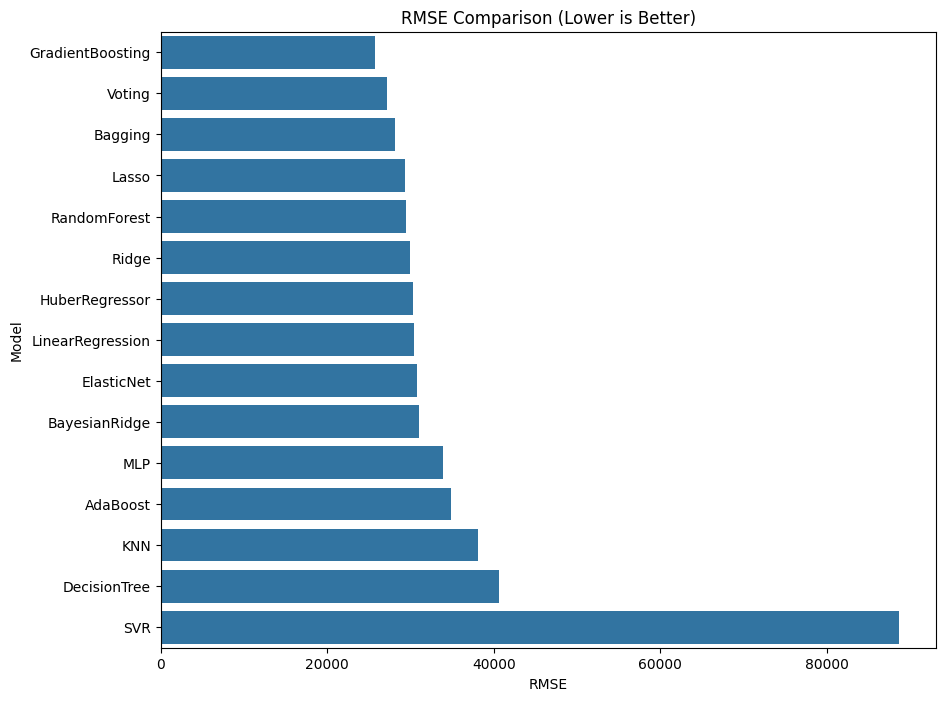

In [12]:
plt.figure(figsize=(10, 8))
sns.barplot(x="RMSE", y="Model", data=results_df)
plt.title("RMSE Comparison (Lower is Better)")
plt.show()


In [14]:
# Save results for reference
results_df.to_csv("../reports/experiment_results.csv", index=False)


### Model Selection Decision

- Best performing model: **GradientBoostingRegressor**
- RMSE ≈ **25k**
- Strong bias–variance tradeoff
- Stable performance compared to ensembles and neural models

➡️ **GradientBoostingRegressor will be used in `train.py`**
